[*********************100%***********************]  1 of 1 completed

Price      Close       High        Low       Open   Volume  Close_Change  \
0      24.241402  24.258643  24.137953  24.258643  1003200           NaN   
1      24.413820  24.413820  24.258648  24.258648   480500      0.711257   
2      24.465544  24.482785  24.344854  24.396578   201300      0.211861   
3      24.724169  24.741410  24.482789  24.500031   529400      1.057099   
4      24.827623  24.879348  24.534519  24.810382   531500      0.418435   

Price  High_Change  Low_Change  Open_Change  Volume_Change  
0              NaN         NaN          NaN            NaN  
1         0.639678    0.500019     0.000019     -52.103270  
2         0.282483    0.355363     0.568583     -58.106139  
3         1.056355    0.566589     0.424045     162.990561  
4         0.557516    0.211293     1.266739       0.396675  
Index(['Close_Change', 'High_Change', 'Low_Change', 'Open_Change',
       'Volume_Change', 'Target'],
      dtype='object', name='Price')
Optimization terminated successfully.
 

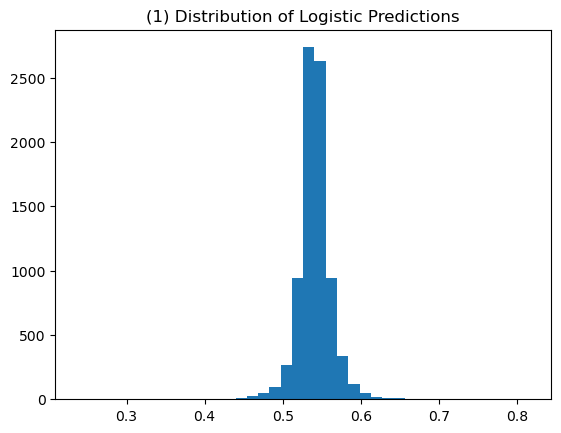

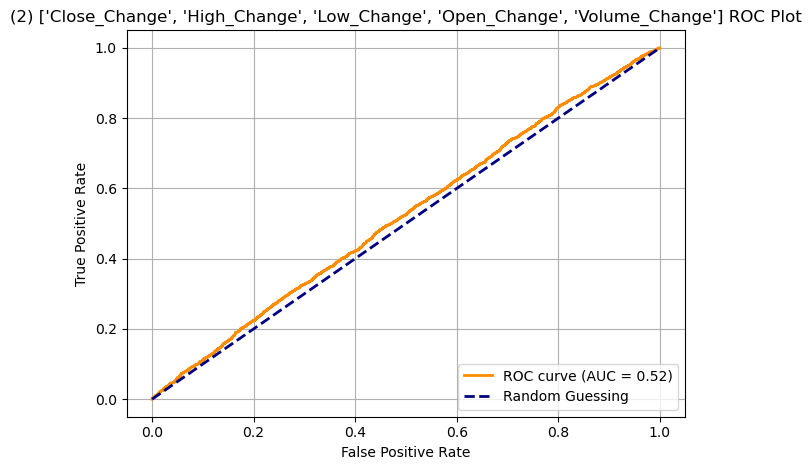

Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,Close + 1,Target,Prediction
1,24.413820,24.413820,24.258648,24.258648,480500,0.711257,0.639678,0.500019,0.000019,-52.103270,24.465544,1,1.0
2,24.465544,24.482785,24.344854,24.396578,201300,0.211861,0.282483,0.355363,0.568583,-58.106139,24.724169,1,1.0
3,24.724169,24.741410,24.482789,24.500031,529400,1.057099,1.056355,0.566589,0.424045,162.990561,24.827623,1,1.0
4,24.827623,24.879348,24.534519,24.810382,531500,0.418435,0.557516,0.211293,1.266739,0.396675,24.810368,0,1.0
5,24.810368,24.862092,24.672436,24.810368,492100,-0.069502,-0.069358,0.562134,-0.000058,-7.412982,24.810368,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,679.751404,686.850422,677.169008,686.142492,113160300,-1.075200,-0.053678,-0.439770,0.442244,31.316515,678.724426,0,1.0
8276,678.724426,683.739636,677.248806,683.719676,90811000,-0.151081,-0.452906,0.011784,-0.353107,-19.750124,676.869934,0,1.0
8277,676.869934,679.073445,672.991380,677.228859,122030600,-0.273232,-0.682451,-0.628635,-0.949339,34.378655,669.421936,0,1.0
8278,669.421936,678.435280,669.222513,677.886913,110625200,-1.100359,-0.093976,-0.560017,0.097169,-9.346344,674.476929,1,1.0


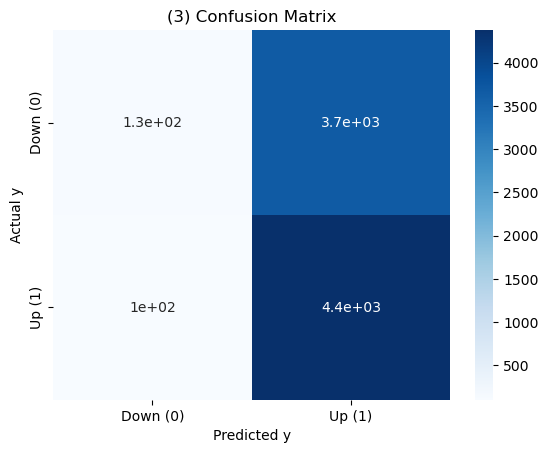

In [ ]:
import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc #pip install scikit-learn
import yfinance_fix

TICKER = "SPY"
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

SHIFT = 1 
STRATEGY = ['Close_Change', 'High_Change', 'Low_Change', 'Open_Change', 'Volume_Change']
LOOKBACK = 10000

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)
    if df.empty: # Recognize yfinance Error
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    df.columns = df.columns.get_level_values(0)

    for c in df.columns:
        df[f"{c}_Change"] = df[f"{c}"].pct_change()*100 #*100: um in Percentage Terms zu interpretieren

    df = df.reset_index(drop=True)
    print(df.head())
    return df.iloc[-lookback:, :]

# Add Target 
def add_target(df, shift = SHIFT):

    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1

    return df

# --- (5) Generate Logistic Regression Output ---
def generate_log_reg_output(df, features=STRATEGY, target="Target"):

    subset = df[features + [target]].dropna()
    print(subset.columns)
    X = subset[features] 
    y = subset[target] 
    X_with_const = sm.add_constant(X)
    
    model = sm.Logit(y, X_with_const).fit()

    # We need the predicted Values of y. 
    y_pred_prob = model.predict(X_with_const)
    plt.figure()
    plt.hist(y_pred_prob, bins = 40)
    plt.title("(1) Distribution of Logistic Predictions")
    ## Everything left to 0.5 will be a 0 and everything right to 0.5 will be a 1
    # A perefct distribution would be ceneterd around 0.5, but that is rare, because most datasets are skewed

    y_pred = (y_pred_prob > .5).astype(int) # List of responses that are either 0 or 1
    # we can change our cutoff to above the mean, .54 and with that we can actually have a better distribution, 
    # as well as a confucion matrix, so the model becomes a little bit more useful 
    
    # Console Summary
    print(model.summary())
    df["Prediction"] = y_pred

    # ValueError: Input y_pred contains NaN
        # Issue erkennen:
    print("NaNs in Prediction:", df["Prediction"].isna().sum())
        # Am Anfang: pct_change() erzeugt in der ersten Zeile ein NaN, da es keinen vorherigen Wert gibt.
        # Am Ende: shift(-1) erzeugt in der letzten Zeile ein NaN, da es keinen "morgigen" Preis gibt.
        # Lösung: return df.dropna()

    return df.dropna(), y, y_pred_prob

# --- (6) Analyze Logistic Regression Output ---
def add_confusion_matrix(df):

    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()

    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

    return df

# ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(df, y_true, y_scores, title=f"(2) {STRATEGY} ROC Plot"):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def main():

    df = get_data()
    df = add_target(df)
    df, y, y_pred_prob = generate_log_reg_output(df)
    df = add_roc_plot(df, y_true=y, y_scores=y_pred_prob)
    df = add_confusion_matrix(df)

    return df 

df = main()
df


In [22]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Change', 'High_Change',
       'Low_Change', 'Open_Change', 'Volume_Change', 'Close + 1', 'Target',
       'Prediction'],
      dtype='object', name='Price')

In [23]:
df

Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,Close + 1,Target,Prediction
1,24.413820,24.413820,24.258648,24.258648,480500,0.711257,0.639678,0.500019,0.000019,-52.103270,24.465544,1,1.0
2,24.465544,24.482785,24.344854,24.396578,201300,0.211861,0.282483,0.355363,0.568583,-58.106139,24.724169,1,1.0
3,24.724169,24.741410,24.482789,24.500031,529400,1.057099,1.056355,0.566589,0.424045,162.990561,24.827623,1,1.0
4,24.827623,24.879348,24.534519,24.810382,531500,0.418435,0.557516,0.211293,1.266739,0.396675,24.810368,0,1.0
5,24.810368,24.862092,24.672436,24.810368,492100,-0.069502,-0.069358,0.562134,-0.000058,-7.412982,24.810368,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,679.751404,686.850422,677.169008,686.142492,113160300,-1.075200,-0.053678,-0.439770,0.442244,31.316515,678.724426,0,1.0
8276,678.724426,683.739636,677.248806,683.719676,90811000,-0.151081,-0.452906,0.011784,-0.353107,-19.750124,676.869934,0,1.0
8277,676.869934,679.073445,672.991380,677.228859,122030600,-0.273232,-0.682451,-0.628635,-0.949339,34.378655,669.421936,0,1.0
8278,669.421936,678.435280,669.222513,677.886913,110625200,-1.100359,-0.093976,-0.560017,0.097169,-9.346344,674.476929,1,1.0
